# 1. Project Topic and Goal

- GitHub Repo: https://github.com/wr0b1n/MSDS-5511-FinalProject
- Kaggle Competition: https://www.kaggle.com/competitions/store-sales-time-series-forecasting

This project revolves around a Kaggle competition in the field of time series forecasting. Time series data is a specific type of data that measures certain observations at regular time intervals, enabling us to perform various tasks like predicting future sales, stock prices or weather patterns. In this competition, the primary goal is to develop accurate forecasting models for store sales, which is of a major interest in retail and demand planning. We will work with two model, namely a LSTM neural network and the Facebook Prophet model.

As the main goal for the project we want to address the challenge of predicting future sales at a granular level for multiple stores and items. Accurate sales forecasts are essential for optimizing inventory management and ensuring customer satisfaction. We are provided with a dataset containing historical sales data for different stores and items, along with various additional features such as store information, item details, and external factors like national holidays or oil prices that could impact our sales numbers. Since we are provided with training and test data, we are working on a supervised machine learning task. For assessing model performance the results will be evaluated on the test data using the Root Mean Squared Logarithmic Error (RMSLE).

# 2. Data

Since we are working on a Kaggle competition, we are provided with all the required data which can be found here:
- https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

There are multiple data files while all of them are in CSV format which can be processed easily by the Pandas library. We have a file containing the training data which is also the largest file with a size of over 100 MB. This is quite large for a CSV file but considering the available computing power we probably don't need to worry about special techniques for handling large amounts of data.

The training file itself has 6 columns, containing information about the date, the store number, the number of items sold, and more. It seems like there are various data types as we have numerical data, categorical data and also datetime values. There even seem to be foreign keys (ID's) that refer to other CSV files available. For example, we have a separate file containing only meta data about the stores.

Besides the training file we are also provided with a test file that looks similar to the training file except for the missing sales numbers which will be our task to predict. There is even a sample submission file that shows us how our final result needs to look like in order to achieve a valid score on the leaderboard.

As already mentioned there are additional files containing meta data. There are also files containing further information like special holidays or oil prices during the time of interest. We have to decide later which of the available information is relevant for our model and therefore how much of it we need to incorporate.

# 3. Import Python Libraries

Let's import the required libraries for our project.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.layers import Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from prophet import Prophet

import os
import random

Set all required seeds for better reproducibility.

In [2]:
np.random.seed(100)
tf.random.set_seed(100)
os.environ['PYTHONHASHSEED'] = '0'
random.seed(100)

# 4. Exploratory Data Analysis

First, we load all datasets into memory.

In [3]:
# main data
df_train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
df_test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')

# additional and meta data
df_transactions = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')
df_holiday = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
df_oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
df_stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')

# read submission example
df_submission = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv')

## 4.1 Data Cleaning

### 4.1.1 Missing Values

Let's check for null or missing values in our training and test data.

In [4]:
df_train.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           3000888 non-null  int64  
 1   date         3000888 non-null  object 
 2   store_nbr    3000888 non-null  int64  
 3   family       3000888 non-null  object 
 4   sales        3000888 non-null  float64
 5   onpromotion  3000888 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
df_test.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


As we can see we have over 3 million training entries, over 28 thousand test entries and no missing values. Next let's inspect the additional datasets.

In [6]:
df_transactions.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [7]:
df_holiday.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [8]:
df_oil.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [9]:
df_stores.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


The output shows that our data files have no missing values except for the oil dataset. Let's have a closer look at those.

In [10]:
df_oil.head(30)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


There are indeed some NaN values in the column that contains the oil price. If we look closer we can also see that there are some missing dates in the date column. Looking those dates up in the calender shows that these are the weekends. As far as I know the stock market is involved in building those oil prices and the market is closed during weekends (and maybe also holidays). This means the oil price is fixed during this time and we can simply impute the last available value from the day before.

First, we fill up the missing date values. This is necessary if we want to combine this information with the training dataset which has no missing date values as a quick check shows us.

In [11]:
# check if there are also missing dates in the training data
unique_values = df_train['date'].unique()
print(unique_values[:10])

['2013-01-01' '2013-01-02' '2013-01-03' '2013-01-04' '2013-01-05'
 '2013-01-06' '2013-01-07' '2013-01-08' '2013-01-09' '2013-01-10']


As suspected, the training data contains weekend dates in contrast to the oil price dataset. This means we fill up the missing values. But first, converting the date columns in all datasets to the correct data type will help us here and also later on.

In [12]:
# convert to datetime data type 
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_holiday['date'] = pd.to_datetime(df_holiday['date'])

In [13]:
# create complete date range with daily ('D') frequency
start_date = df_oil['date'].min()
end_date = df_oil['date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
complete_df = pd.DataFrame({'date': date_range})

# merge the dataframes
df_oil = complete_df.merge(df_oil, on='date', how='left')

In [14]:
# forward fill the NaN values
df_oil['dcoilwtico'].fillna(method='ffill', inplace=True)

In [15]:
df_oil.head(30)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12
5,2013-01-06,93.12
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


This looks much better but there is still one NaN value. Since we cannot forward fill the first row we will simply drop it. This should be safe because it lies furthest in the past and should have not much of an impact on our model (we still have lots of data rows left!). Of course we have to drop this specific date in other datasets as well to preserve consistency.

In [16]:
# remove first row in all datasets with a 'date' column
df_oil = df_oil[df_oil['date'] != '2013-01-01']
df_train = df_train[df_train['date'] != '2013-01-01']
df_transactions = df_transactions[df_transactions['date'] != '2013-01-01']

In [17]:
# example output without first row
df_oil.head(10)

,date,dcoilwtico
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12
5,2013-01-06,93.12
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81
10,2013-01-11,93.60


Now we are finished with handling missing values and we will continue by inspecting our data in more detail.

### 4.1.2 Data Inspection

First, we plot the number of sales over time.

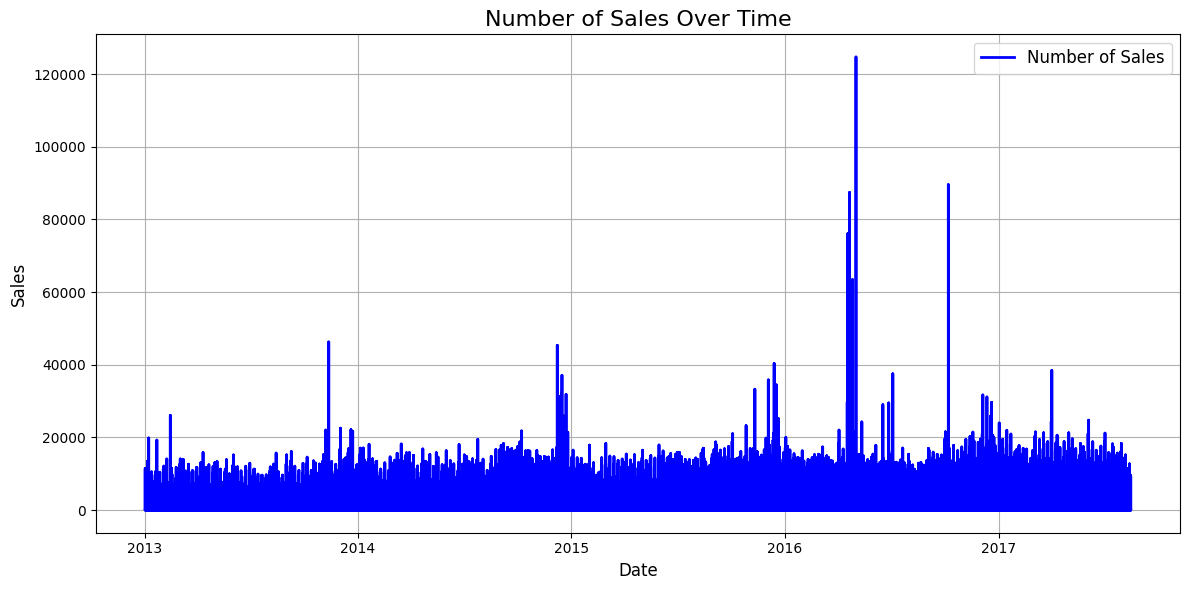

In [18]:
# plot number of sales over time
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['sales'], label='Number of Sales', color='blue', linewidth=2)
plt.title('Number of Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

There are multiple things to notice. Our training data starts with the beginning of the year 2013 and ends in the middle of August in 2017 (our test data starts right after this point and ends on the last day of August in 2017). Overall the sales numbers seem to be pretty constant with a slight increase over time. But there are also some outliers with sales numbers up to roughly 6 times as high as normal. To get some context we could relate this information to the oil price during that time. 

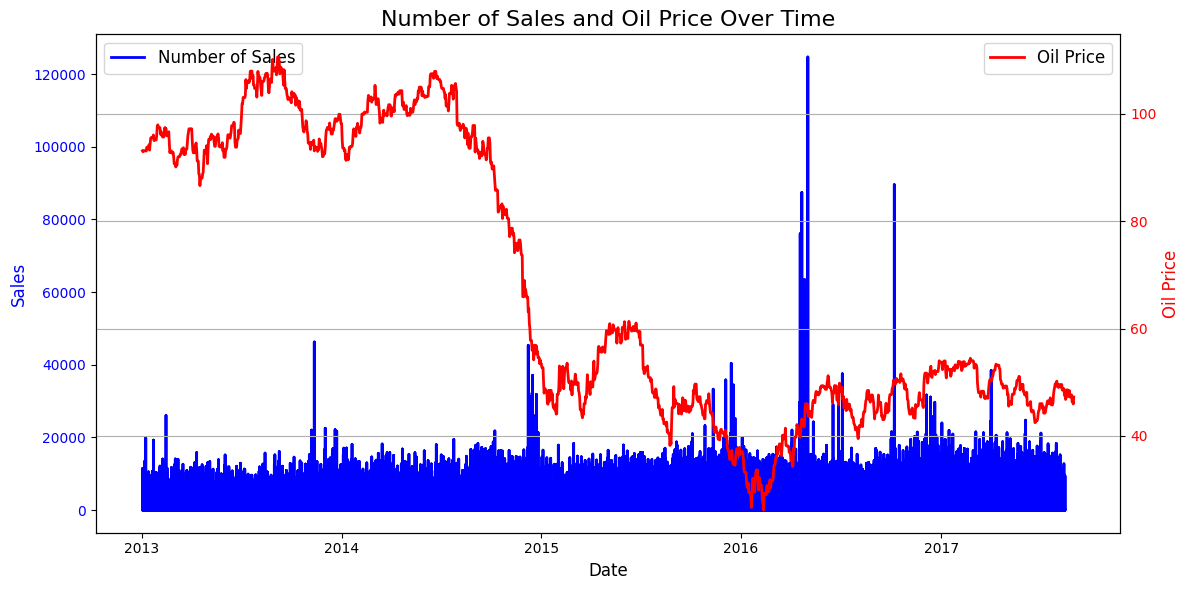

In [19]:
# plot both the number of sales and oil price on the same plot
fig, ax1 = plt.subplots(figsize=(12, 6))
plt.title('Number of Sales and Oil Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)

# number of sales
ax1.plot(df_train['date'], df_train['sales'], label='Number of Sales', color='blue', linewidth=2)
ax1.set_ylabel('Sales', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left', fontsize=12)

# oil price
ax2 = ax1.twinx()
ax2.plot(df_oil['date'], df_oil['dcoilwtico'], label='Oil Price', color='red', linewidth=2)
ax2.set_ylabel('Oil Price', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right', fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

We recognize that at the end of the years 2014 and 2015 and also at the beginning of 2016 there was a significant decrease in oil price directly followed by a remarkable increase in sales numbers. This indicates that there might be some correlation between those variables.

The training dataset contains another interesting information, namely how many items for a given product family were being promoted at a store at a given date. We can visually inspect how this correlates with the number of items sold. For better visibility we only look at the period of the last year available.

In [20]:
# only look at data from last year
df_last_year = df_train[df_train['date'] >= df_train['date'].max() - pd.DateOffset(years=1)]

# group numbers by date
df_last_year = df_last_year.groupby('date').agg({'sales': 'sum', 'onpromotion': 'sum'}).reset_index()

df_last_year.head(10)

,date,sales,onpromotion
0,2016-08-15,720032.299881,6925
1,2016-08-16,718671.651353,8896
2,2016-08-17,725945.703034,14445
3,2016-08-18,577350.520939,6847
4,2016-08-19,678767.115815,12171
5,2016-08-20,828986.335840,7317
6,2016-08-21,901870.149939,8091
7,2016-08-22,714866.233843,6907
8,2016-08-23,660819.977976,8720
9,2016-08-24,674613.047950,13484


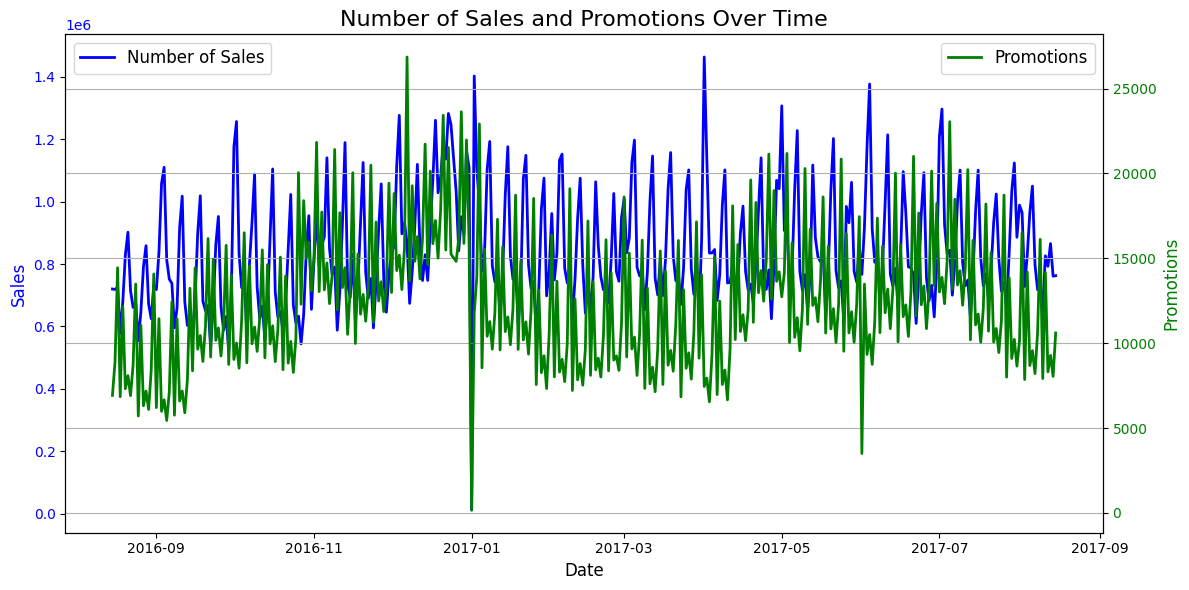

In [21]:
# plot both the number of sales and oil price on the same plot
fig, ax1 = plt.subplots(figsize=(12, 6))
plt.title('Number of Sales and Promotions Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)

# number of sales
ax1.plot(df_last_year['date'], df_last_year['sales'], label='Number of Sales', color='blue', linewidth=2)
ax1.set_ylabel('Sales', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left', fontsize=12)

# promotions
ax2 = ax1.twinx()
ax2.plot(df_last_year['date'], df_last_year['onpromotion'], label='Promotions', color='green', linewidth=2)
ax2.set_ylabel('Promotions', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right', fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

From the plot we would suspect that there is a strong correlation between those two lines. More promotions seems likely to have a positive impact on the number of sales. Let's check this numerically. 

In [22]:
# calculate correlation between sales and promotions
correlation = df_last_year['sales'].corr(df_last_year['onpromotion'])
print("Correlation between Number of sales and Promotions:", round(correlation, 4))

Correlation between Number of sales and Promotions: 0.1144


However, this result suggests that there is no strong correlation! Finally, we have a closer look at the holiday dataset.

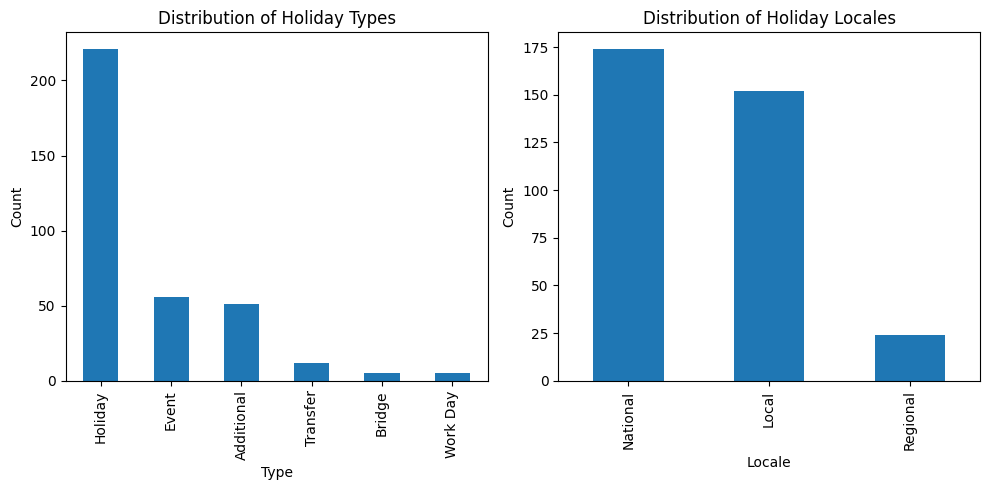

In [23]:
# histogram for 'type' column
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df_holiday['type'].value_counts().plot(kind='bar')
plt.title('Distribution of Holiday Types')
plt.xlabel('Type')
plt.ylabel('Count')

# histogram for 'locale' column
plt.subplot(1, 2, 2)
df_holiday['locale'].value_counts().plot(kind='bar')
plt.title('Distribution of Holiday Locales')
plt.xlabel('Locale')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

We can see that indeed most of those special days are holidays whereas most of them are either national or local ones.

We are now finished with the EDA part and got a better knowledge of our dataset. There is lots of additional information that we could incorporate into our model. However, for this project we want to focus only on the main information given to us. This means we will only work with training dataset but keep in mind that we potentially could improve our model by making use of the additional datasets.

# 5. Data Preprocessing

Many of the following preprocessing steps will be performed for train and test data simultaneously. Now that we got a better understanding for our data and performed some cleaning steps we are ready to preprocess the data such that it can be used by our models. Since we want to work with different models we will do some common steps first.

## 5.1 Preparing Datasets

We remove the 'onpromotion' column from the training dataset since we won't use it.

In [24]:
df_train = df_train.drop(columns=['onpromotion'])
df_test = df_test.drop(columns=['onpromotion'])

We move the 'sales' feature to the right end of the dataset which is more convenient. 

In [25]:
# bring the feature to predict to the right end
df_train['sales'] = df_train.pop('sales')

In [26]:
df_train.head()

,id,date,store_nbr,family,sales
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0
1783,1783,2013-01-02,1,BABY CARE,0.0
1784,1784,2013-01-02,1,BEAUTY,2.0
1785,1785,2013-01-02,1,BEVERAGES,1091.0
1786,1786,2013-01-02,1,BOOKS,0.0


In [27]:
df_test.head()

,id,date,store_nbr,family
0,3000888,2017-08-16,1,AUTOMOTIVE
1,3000889,2017-08-16,1,BABY CARE
2,3000890,2017-08-16,1,BEAUTY
3,3000891,2017-08-16,1,BEVERAGES
4,3000892,2017-08-16,1,BOOKS


In [28]:
print("Shape of training data: ", df_train.shape)
print("Shape of test data: ", df_test.shape)

Shape of training data:  (2999106, 5)
Shape of test data:  (28512, 4)


## 5.2 Feature Engineering for LSTM

Because we want to work with different models we will do the specifc feature engineering for each one separately. We start with the LSTM prerequisites. For this purpose, we create a fresh copy of the training and test dataset. 

In [29]:
df_train_lstm = df_train.copy()
df_test_lstm = df_test.copy()

LSTM models can only work with numerical data which is why we have to encode the family feature.

In [30]:
# encode the family feature as a numerical value
ordinal_encoder = OrdinalEncoder(dtype=int)
df_train_lstm[['family']] = ordinal_encoder.fit_transform(df_train_lstm[['family']])
df_test_lstm[['family']] = ordinal_encoder.transform(df_test_lstm[['family']])

In [31]:
df_train_lstm.head()

,id,date,store_nbr,family,sales
1782,1782,2013-01-02,1,0,2.0
1783,1783,2013-01-02,1,1,0.0
1784,1784,2013-01-02,1,2,2.0
1785,1785,2013-01-02,1,3,1091.0
1786,1786,2013-01-02,1,4,0.0


In [32]:
df_test_lstm.head()

,id,date,store_nbr,family
0,3000888,2017-08-16,1,0
1,3000889,2017-08-16,1,1
2,3000890,2017-08-16,1,2
3,3000891,2017-08-16,1,3
4,3000892,2017-08-16,1,4


Our time series data contains multiple dimensions, such as multiple stores and products. In order to model all this information correctly, we can build a pivot table from our dataframe. This way we organize the data into separate time series, making it easier to feed into the LSTM model.

In [33]:
# build a pivot table from the dataframe
pivot_train_lstm = df_train_lstm.pivot(index=['date'], columns=['store_nbr', 'family'], values='sales')
pivot_train_lstm.head()

store_nbr     1                                                               \
family       0    1    2       3    4        5    6       7      8        9    
date                                                                           
2013-01-02  2.0  0.0  2.0  1091.0  0.0  470.652  0.0  1060.0  579.0  164.069   
2013-01-03  3.0  0.0  0.0   919.0  0.0  310.655  0.0   836.0  453.0  151.582   
2013-01-04  3.0  0.0  3.0   953.0  0.0  198.366  0.0   827.0  460.0  131.411   
2013-01-05  5.0  0.0  3.0  1160.0  0.0  301.057  0.0   811.0  464.0  118.613   
2013-01-06  2.0  0.0  0.0   407.0  0.0  147.182  0.0   257.0  212.0   60.135   

store_nbr   ...    9                                                     \
family      ...   23       24     25   26   27       28    29   30   31   
date        ...                                                           
2013-01-02  ...  0.0  374.531  482.0  0.0  0.0  651.292  83.0  0.0  0.0   
2013-01-03  ...  0.0  400.863  372.0  0.0  0.0  509.496  66.0  0.0  0.0   
2013-01-04  ...  0.0  310.878  324.0  0.0  0.0  332.672  57.0  0.0  0.0   
2013-01-05  ...  0.0  447.685  461.0  0.0  0.0  510.919  84.0  0.0  0.0   
2013-01-06  ...  0.0  555.051  618.0  0.0  0.0  604.244  82.0  0.0  0.0   

store_nbr           
family          32  
date                
2013-01-02  29.214  
2013-01-03  25.000  
2013-01-04  11.000  
2013-01-05  28.361  
2013-01-06  36.553  

[5 rows x 1782 columns]

This looks great! We can now split our data into and training and validation datasets. We will use 95% as training and 5% as validation data.

In [34]:
# split training and validation data
number_train_samples = int(df_train_lstm["date"].nunique() * 0.95)
pivot_train_lstm_train = pivot_train_lstm[:number_train_samples]
pivot_train_lstm_valid = pivot_train_lstm[number_train_samples:]

In [35]:
pivot_train_lstm_train.head()

store_nbr     1                                                               \
family       0    1    2       3    4        5    6       7      8        9    
date                                                                           
2013-01-02  2.0  0.0  2.0  1091.0  0.0  470.652  0.0  1060.0  579.0  164.069   
2013-01-03  3.0  0.0  0.0   919.0  0.0  310.655  0.0   836.0  453.0  151.582   
2013-01-04  3.0  0.0  3.0   953.0  0.0  198.366  0.0   827.0  460.0  131.411   
2013-01-05  5.0  0.0  3.0  1160.0  0.0  301.057  0.0   811.0  464.0  118.613   
2013-01-06  2.0  0.0  0.0   407.0  0.0  147.182  0.0   257.0  212.0   60.135   

store_nbr   ...    9                                                     \
family      ...   23       24     25   26   27       28    29   30   31   
date        ...                                                           
2013-01-02  ...  0.0  374.531  482.0  0.0  0.0  651.292  83.0  0.0  0.0   
2013-01-03  ...  0.0  400.863  372.0  0.0  0.0  509.496  66.0  0.0  0.0   
2013-01-04  ...  0.0  310.878  324.0  0.0  0.0  332.672  57.0  0.0  0.0   
2013-01-05  ...  0.0  447.685  461.0  0.0  0.0  510.919  84.0  0.0  0.0   
2013-01-06  ...  0.0  555.051  618.0  0.0  0.0  604.244  82.0  0.0  0.0   

store_nbr           
family          32  
date                
2013-01-02  29.214  
2013-01-03  25.000  
2013-01-04  11.000  
2013-01-05  28.361  
2013-01-06  36.553  

[5 rows x 1782 columns]

In [36]:
pivot_train_lstm_valid.head()

store_nbr     1                                                               \
family       0    1    2       3    4        5     6      7      8        9    
date                                                                           
2017-05-23  4.0  0.0  1.0  2365.0  1.0  413.152   8.0  822.0  736.0  127.909   
2017-05-24  7.0  0.0  1.0  2611.0  1.0  349.681  11.0  944.0  867.0  166.068   
2017-05-25  2.0  0.0  1.0  2229.0  0.0  372.385  18.0  706.0  723.0  122.562   
2017-05-26  1.0  0.0  0.0  1100.0  0.0  190.733   7.0  303.0  375.0   82.697   
2017-05-27  1.0  0.0  2.0  2270.0  0.0  300.786  10.0  462.0  634.0   99.587   

store_nbr   ...    9                                                 \
family      ...   23       24     25   26    27         28       29   
date        ...                                                       
2017-05-23  ...  1.0  284.679  340.0  5.0  12.0  328.32900  127.406   
2017-05-24  ...  1.0  318.254  292.0  6.0  12.0  360.76498  104.618   
2017-05-25  ...  1.0  415.299  260.0  7.0  10.0  261.97600  110.957   
2017-05-26  ...  5.0  378.795  382.0  9.0   9.0  533.20300  169.919   
2017-05-27  ...  3.0  412.021  455.0  8.0  11.0  541.38000  134.748   

store_nbr                            
family             30    31      32  
date                                 
2017-05-23  2268.3320   1.0  16.063  
2017-05-24  1180.0780   2.0  18.163  
2017-05-25   920.1430   5.0   2.994  
2017-05-26  1515.1750  13.0  20.683  
2017-05-27  1634.6849   5.0  43.512  

[5 rows x 1782 columns]

In order to obtain reasonable model results and avoid exploding loss values we have to scale our numeric values on a new range from 0 up to 1. The resulting datatype will be numpy array.

In [37]:
# scale numeric features on a scale 0 to 1
minmax = MinMaxScaler()
minmax.fit(pivot_train_lstm_train)

pivot_train_lstm_train_scaled = minmax.transform(pivot_train_lstm_train)
pivot_train_lstm_valid_scaled = minmax.transform(pivot_train_lstm_valid)

In [38]:
pivot_train_lstm_train_scaled[:5]

array([[0.11111111, 0.        , 0.16666667, ..., 0.        , 0.        ,
        0.48512928],
       [0.16666667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.41515136],
       [0.16666667, 0.        , 0.25      , ..., 0.        , 0.        ,
        0.1826666 ],
       [0.27777778, 0.        , 0.25      , ..., 0.        , 0.        ,
        0.47096431],
       [0.11111111, 0.        , 0.        , ..., 0.        , 0.        ,
        0.60700111]])

In [39]:
pivot_train_lstm_valid_scaled[:5]

array([[0.22222222, 0.        , 0.08333333, ..., 0.55871526, 0.00306748,
        0.26674305],
       [0.38888889, 0.        , 0.08333333, ..., 0.29066626, 0.00613497,
        0.30161577],
       [0.11111111, 0.        , 0.08333333, ..., 0.2266414 , 0.01533742,
        0.04971853],
       [0.05555556, 0.        , 0.        , ..., 0.37320436, 0.0398773 ,
        0.34346303],
       [0.05555556, 0.        , 0.16666667, ..., 0.40264097, 0.01533742,
        0.72256265]])

A special preprocessing in the context of time series forecasting is the creation of time series sequences. We need them when we have historical data and want to predict future data points. By splitting the time series data into past and future sequences, we can then use these sequences as input features and target labels for our LSMT model. This way we capture the temporal dependencies.

In [40]:
# method to create time series for past and future
def createTimeSeriesSequences(series, number_past = 16, number_future = 16):
    X, y = [], []
    
    for window_start in range(len(series) - number_past - number_future + 1):
        past_end = window_start + number_past
        future_end = past_end + number_future
       
        past = series[window_start:past_end, :]
        future = series[past_end:future_end, :]
        
        X.append(past)
        y.append(future)
    
    return np.array(X), np.array(y)

Our test data has a date range of 16 days. Therefore, it makes sense to set the number of past and future elements to exactly this number. 

In [41]:
# some constants and helper variables
number_past = 16
number_future = 16
number_features = df_train_lstm["store_nbr"].nunique() * df_train_lstm["family"].nunique()

# create the time series sequences
X_train, y_train = createTimeSeriesSequences(pivot_train_lstm_train_scaled, number_past, number_future)
X_valid, y_valid = createTimeSeriesSequences(pivot_train_lstm_valid_scaled, number_past, number_future)

In [42]:
print("Shape of X train: ", X_train.shape)
print("Shape of y train: ", y_train.shape)

Shape of X train:  (1567, 16, 1782)
Shape of y train:  (1567, 16, 1782)


In [43]:
print("Shape of X valid: ", X_valid.shape)
print("Shape of y valid: ", y_valid.shape)

Shape of X valid:  (54, 16, 1782)
Shape of y valid:  (54, 16, 1782)


## 5.3 Feature Engineering for Facebook Prophet

Before actually building the models we are going to do all the preparation work for the Facebook Prophet as well. We start with a fresh copy of our cleaned datasets.

In [44]:
df_train_fb = df_train.copy()
df_test_fb = df_test.copy()

For our facebook model we only use the date and sales information. Even though mulitvariate models are possible through the use of so called regressors, we don't want to blow up the complexity too much at this point.

In [45]:
# drop unused columns
df_train_fb = df_train_fb.drop(columns=['id'])
df_train_fb = df_train_fb.drop(columns=['store_nbr'])
df_train_fb = df_train_fb.drop(columns=['family'])

df_test_fb = df_test_fb.drop(columns=['id'])
df_test_fb = df_test_fb.drop(columns=['store_nbr'])
df_test_fb = df_test_fb.drop(columns=['family'])

In [46]:
df_train_fb.head()

,date,sales
1782,2013-01-02,2.0
1783,2013-01-02,0.0
1784,2013-01-02,2.0
1785,2013-01-02,1091.0
1786,2013-01-02,0.0


In [47]:
df_test_fb.head()

,date
0,2017-08-16
1,2017-08-16
2,2017-08-16
3,2017-08-16
4,2017-08-16


While working on this project and training the facebook model I encountered issues because of very large RAM requirements. This is why I decided to only incorporate the training data from last year into the facebook model.  

In [48]:
# only use data from last year
last_date = df_train_fb['date'].max()
last_year_date = last_date - pd.DateOffset(years=1)
df_train_fb = df_train_fb[df_train_fb['date'] >= last_year_date]

For the LSTM model we solved the problem of redundant date values by creating a pivot table and introducing extra columns for store number and family. However, for the prophet model we dropped those columns beforehand which is why we can't create a proper pivot table here. Instead we aggregate (=sum up) the sales by date.

In [49]:
# aggregate sales by date
df_train_fb = df_train_fb.groupby('date')['sales'].sum().reset_index()

In [50]:
df_train_fb.head()

,date,sales
0,2016-08-15,720032.299881
1,2016-08-16,718671.651353
2,2016-08-17,725945.703034
3,2016-08-18,577350.520939
4,2016-08-19,678767.115815


The facebook prophet model has the special requirement that the column containing the time information has to be named 'ds' and the column containing the value to forecast has to be named 'y'.

In [51]:
# renaming for facebook prophet
df_train_fb.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

In [52]:
df_train_fb.head()

,ds,y
0,2016-08-15,720032.299881
1,2016-08-16,718671.651353
2,2016-08-17,725945.703034
3,2016-08-18,577350.520939
4,2016-08-19,678767.115815


We are now finished with preparing our datasets and can move on to the actual model building.

# 6. Model Building

The plan is start with the LSTM model including a hyperparameter tuning on some parameters like the learning rate. Then we follow up with the Facebook Prophet model to see how it performs in comparison to the LSTM model.

## 6.1 The LSTM Model

We begin with an arbitrary choice of hyperparameters before tuning them. The following code defines our model architecture used for both scenarios. The model has two LSTM layers whereas the first has 256 neurons, and the second has 128 neurons. The batch normalization and dropout layers enhance training stability and prevent overfitting. Finally, the time distributed layer is used for applying dense layers to each time step in the sequences. For the optimizer we choose the Adam and as the optimization metric we take the MSE.

In [53]:
# define the LSTM model architecture
def create_LSTM_Architecture():
    
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=[number_past, number_features]))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(number_features)))
    
    return model

In [54]:
# define a LSTM model
model = create_LSTM_Architecture()

In [55]:
# compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mse'])

In [56]:
# train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=256, validation_data=(X_valid, y_valid))

Epoch 1/30
7/7 [==============================] - 8s 528ms/step - loss: 0.1659 - mse: 0.1659 - val_loss: 0.0865 - val_mse: 0.0865
Epoch 2/30
7/7 [==============================] - 3s 392ms/step - loss: 0.1019 - mse: 0.1019 - val_loss: 0.0838 - val_mse: 0.0838
Epoch 3/30
7/7 [==============================] - 3s 383ms/step - loss: 0.0896 - mse: 0.0896 - val_loss: 0.0797 - val_mse: 0.0797
Epoch 4/30
7/7 [==============================] - 3s 390ms/step - loss: 0.0818 - mse: 0.0818 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 5/30
7/7 [==============================] - 3s 393ms/step - loss: 0.0756 - mse: 0.0756 - val_loss: 0.0698 - val_mse: 0.0698
Epoch 6/30
7/7 [==============================] - 3s 389ms/step - loss: 0.0695 - mse: 0.0695 - val_loss: 0.0661 - val_mse: 0.0661
Epoch 7/30
7/7 [==============================] - 3s 396ms/step - loss: 0.0636 - mse: 0.0636 - val_loss: 0.0594 - val_mse: 0.0594
Epoch 8/30
7/7 [==============================] - 3s 385ms/step - loss: 0.0572 - mse: 0.05

In [57]:
# plot training and validation loss
def plot_LSTM_losses(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

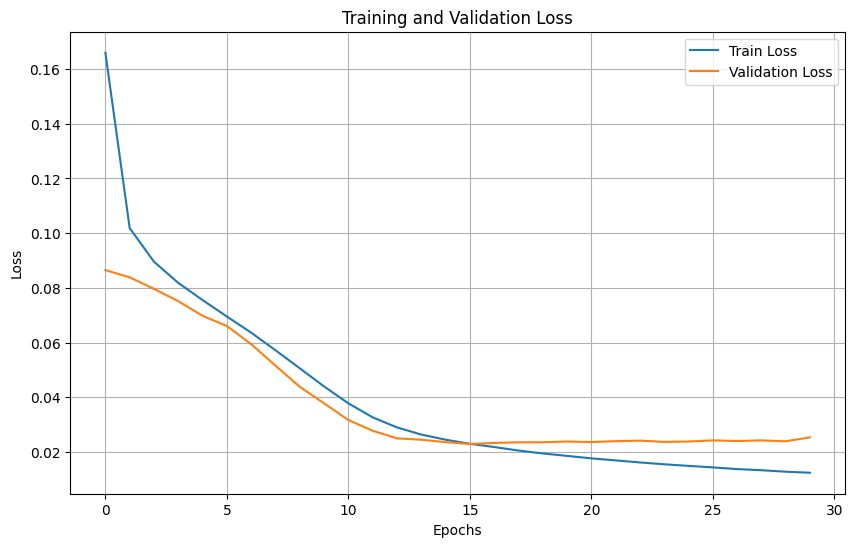

In [58]:
plot_LSTM_losses(history)

The resulting plot looks quite good. The training loss becomes smaller with time and also the validation loss. Now let's perform some hyperparameter tuning on the learning rate and batch size to see if we can optimize our results.

In [59]:
# parameters for tuning
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [64, 128, 256]
}

# store results
results = pd.DataFrame(columns=['Learning Rate', 'Batch Size', 'Validation MSE'])
best_model = None
best_mse = float('inf')
best_history = None

# iterate all parameters to tune
for params in ParameterGrid(param_grid):
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']

    # define model and fit
    model = create_LSTM_Architecture()
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mse'])
    history = model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose = 0)

    # extract the minimum validation MSE from training process
    min_val_mse = min(history.history['val_mse'])

    # store best model
    if min_val_mse < best_mse:
        best_mse = min_val_mse
        best_model = model
        best_history = history
    
    # store hyperparameters and minimum validation MSE
    results.loc[len(results)] = [learning_rate, batch_size, min_val_mse]
    print("Learning Rate: ", learning_rate, ", Batch Size: ", batch_size, ", Validation MSE: ", min_val_mse)

# print results
best_hyperparameters = results.loc[results['Validation MSE'].idxmin()]
print("Best Hyperparameters: ", best_hyperparameters)

Learning Rate:  0.0001 , Batch Size:  64 , Validation MSE:  0.020383354276418686
Learning Rate:  0.001 , Batch Size:  64 , Validation MSE:  0.015107907354831696
Learning Rate:  0.01 , Batch Size:  64 , Validation MSE:  0.014445762149989605
Learning Rate:  0.0001 , Batch Size:  128 , Validation MSE:  0.03958149254322052
Learning Rate:  0.001 , Batch Size:  128 , Validation MSE:  0.019863186404109
Learning Rate:  0.01 , Batch Size:  128 , Validation MSE:  0.01860257424414158
Learning Rate:  0.0001 , Batch Size:  256 , Validation MSE:  0.06966715306043625
Learning Rate:  0.001 , Batch Size:  256 , Validation MSE:  0.023137914016842842
Learning Rate:  0.01 , Batch Size:  256 , Validation MSE:  0.020803013816475868
Best Hyperparameters:  Learning Rate      0.010000
Batch Size        64.000000
Validation MSE     0.014446
Name: 2, dtype: float64


We see that our arbitrary choice of hyperparameters was not the best choice possible. We started with a learning rate of 0.001 and a batch size of 256 but the tuning process shows the best results to be a learning rate of 0.01 and a batch size of 64. Of course, if we had more computing power we should include more parameters into the tuning process and choose a finer step size for the values to tune.

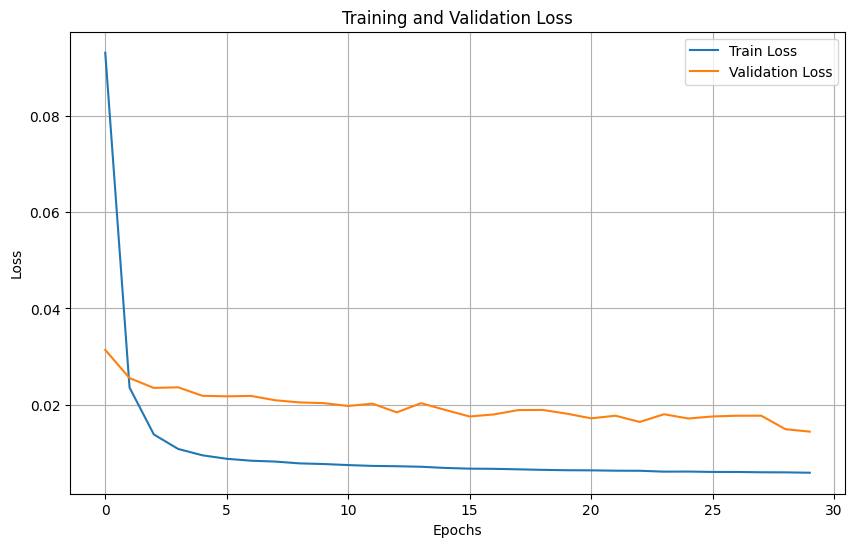

In [60]:
plot_LSTM_losses(best_history)

From the plot we observe that the best hyperparameters indeed work better. The loss of both training and validation is smaller and reaches its minimum earlier. 

## 6.2 The Facebook Prophet Model

https://facebook.github.io/prophet/

The Facebook Prophet decomposes time series data into components, like trend or seasonality. The model uses a generalized additive model (GAM) framework that combines these components along with additional regressors, if provided to make predictions. It can even handle missing data points and is quite robust to changes in data patterns. Therefore, it is widely used for forecasting tasks such as stock prices, and weather predictions.

First, we create a new instance of the prophet model and fit it to our training data.

In [61]:
model_prophet = Prophet()
model_prophet.fit(df_train_fb)

09:34:29 - cmdstanpy - INFO - Chain [1] start processing
09:34:29 - cmdstanpy - INFO - Chain [1] done processing


To see how well our model works we can predict on the train data and compare the predicted values with the one from the training datset.

In [62]:
train_forecast = model_prophet.predict(df_train_fb)

This plot shows the original time series data with components like trends and seasonal effects.

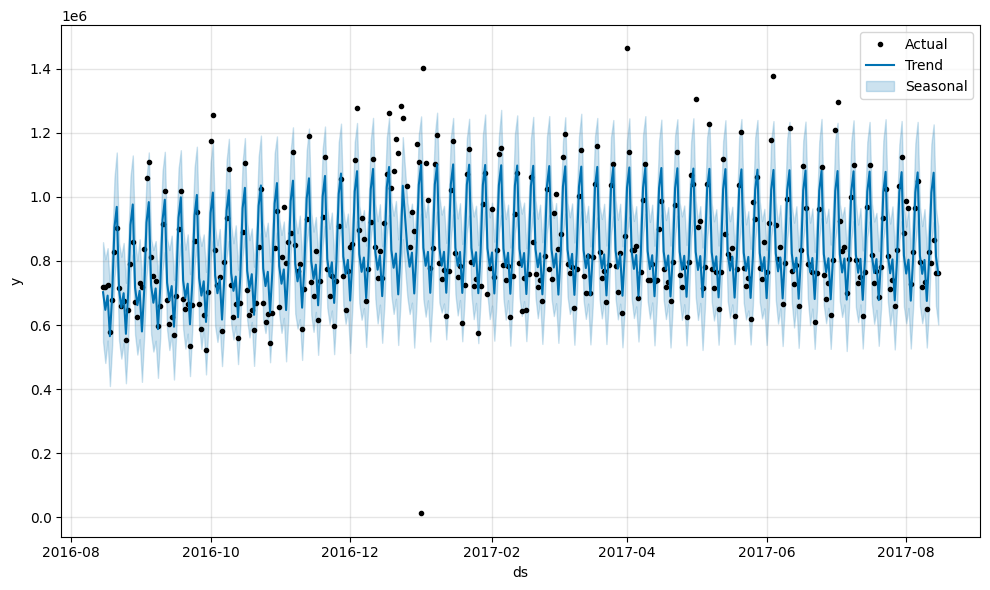

In [63]:
fig = model_prophet.plot(train_forecast)
plt.legend(['Actual', 'Trend', 'Seasonal'])
plt.show()

Its quite hard to see how well the model actually performs. So let's look only at the last 100 days.

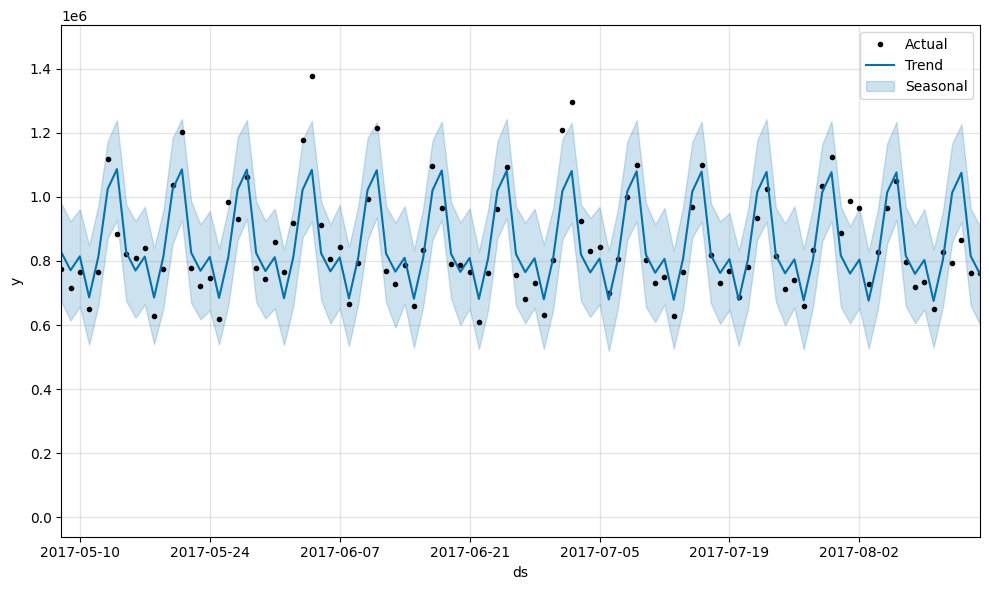

In [64]:
fig = model_prophet.plot(train_forecast.iloc[-100:])
plt.xlim(train_forecast['ds'].iloc[-100], train_forecast['ds'].iloc[-1])
plt.legend(['Actual', 'Trend', 'Seasonal'])
plt.show()

We can clearly see a weekly pattern with increasing and decreasing sales number. This indicates that we have higher numbers on certain days of the week, probably on weekends. Overall, the model captures the trends quite well. However, there a quite a few outliers that are not properly detected. We can also create separate plots for the trend and weekly seasonality components to prove our suggestion of higher sales on weekends.

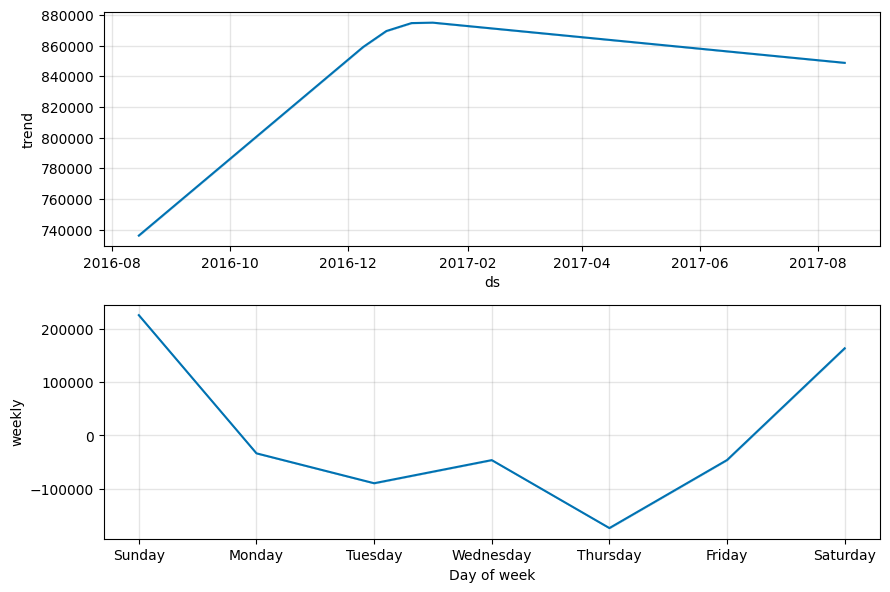

In [65]:
fig = model_prophet.plot_components(train_forecast)

We can notice two interesting but reasonable things from the plots. First, there seems to be a peak at the end of december 2016 which makes sense since many people spend more money during the christmas holidays. And second, on a weekly scale there are higher numbers of sales in weekends, i.e. Saturday and Sunday. This makes also sense because people have more time on weekends to go shopping and spending money than on working days.

Instead of using the prefined plot methods we could also plot the results using the matplot library.

In [66]:
# create a custom plot
def create_prophet_plot(forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(df_train_fb['ds'], df_train_fb['y'], label='Actual', color='blue')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
    plt.title('Prophet Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

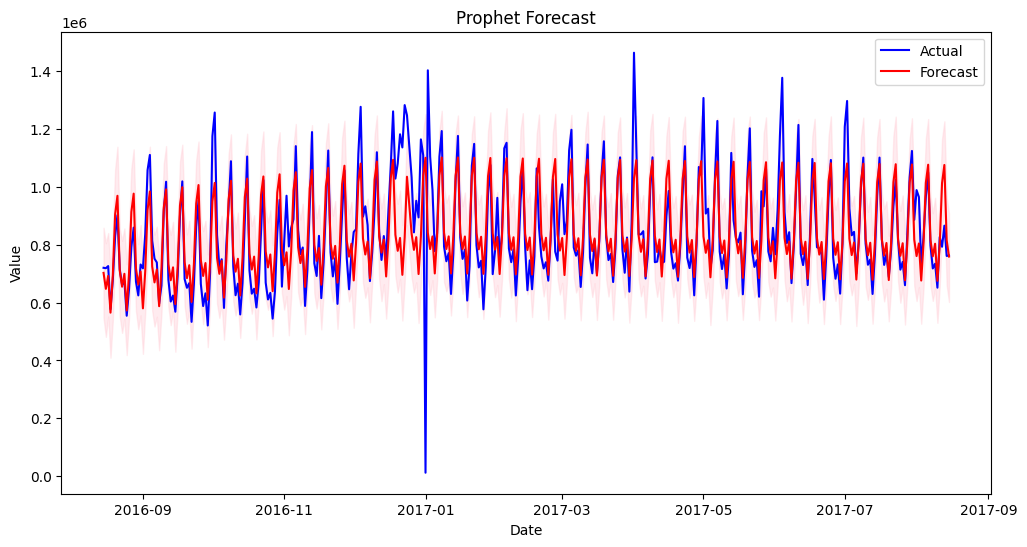

In [67]:
create_prophet_plot(train_forecast)

This is basically the same as the first plot made with the prophet model. Thanks to combining the actual datapoints the outliers are made more visible here.

# 7. Results and Analysis

Now that we worked with both models we want to summarize their results, select the best model and predict on the test data in order to create a submission for the Kaggle competition.

We saw that the LSTM model achieved really small train and validation losses, especially after tuning the hyperparameters. The results from hyperparameter tuning are summarized here.

In [68]:
# LSTM hyperparameter tuning results
results

,Learning Rate,Batch Size,Validation MSE
0,0.0001,64.0,0.020383
1,0.0010,64.0,0.015108
2,0.0100,64.0,0.014446
3,0.0001,128.0,0.039581
4,0.0010,128.0,0.019863
5,0.0100,128.0,0.018603
6,0.0001,256.0,0.069667
7,0.0010,256.0,0.023138
8,0.0100,256.0,0.020803


The best values for the parameters learning rate and batch size are found in row with index number 2 to be 0.01 and 64. This resulted in a validation MSE of 0.014446. Let's look at the loss plot again.

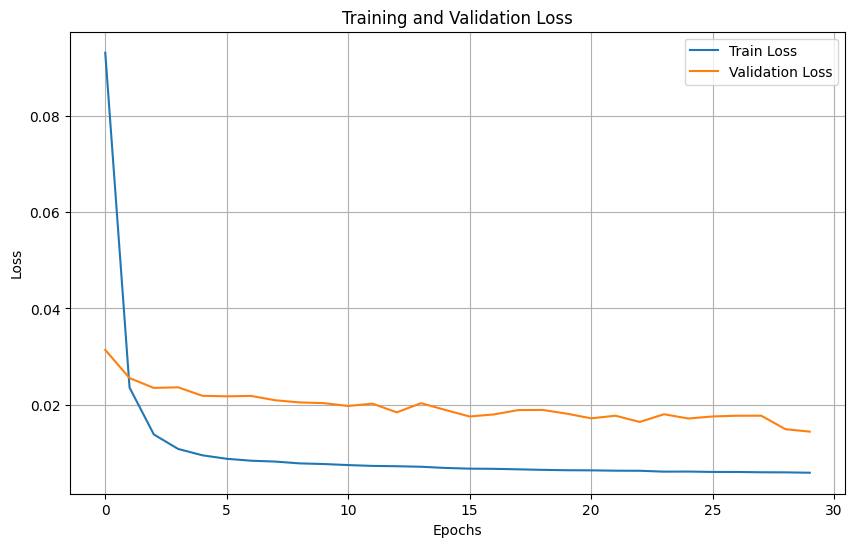

In [69]:
plot_LSTM_losses(best_history)

We see that we have a sharp decline in training loss during the first few epochs and smaller but consistent decline for both the train and validation loss after that. Since we cannot clearly recognize an increase in validation loss we might not have reached the optimal point after 30 epochs yet. But due to the limited computation power in Kaggle we will accept the result we got which is still pretty good.

We also worked with the Facebook Prophet model. However, we ran into RAM issues when feeding the whole training data into the model which is why we only used data from last year. Additionally, we did not incorporate the store number and family information as with the LSTM model. This lack of information probably makes our model not as meaningful as the LSTM model where we worked with pivot tables to include all available data.

However the built-in plot funtions of the Facebook model showed us some meaningful insights into our time series data on which we want to have look again. 

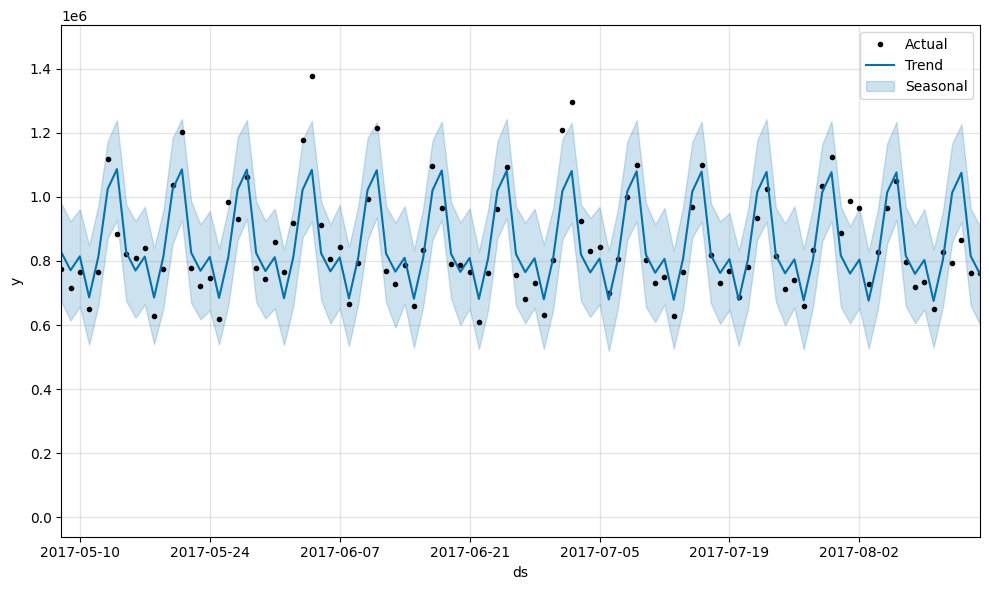

In [70]:
fig = model_prophet.plot(train_forecast.iloc[-100:])
plt.xlim(train_forecast['ds'].iloc[-100], train_forecast['ds'].iloc[-1])
plt.legend(['Actual', 'Trend', 'Seasonal'])
plt.show()

We can clearly that our model captures the general trend of our training data quite well even though there are some outliers. Besides that, we can see ups and downs in our sales numbers which are caused by the weekly trend where we have higher number on weekends. We already discussed this in the model building chapter. This is perfectly reflected in the other plot shown below.

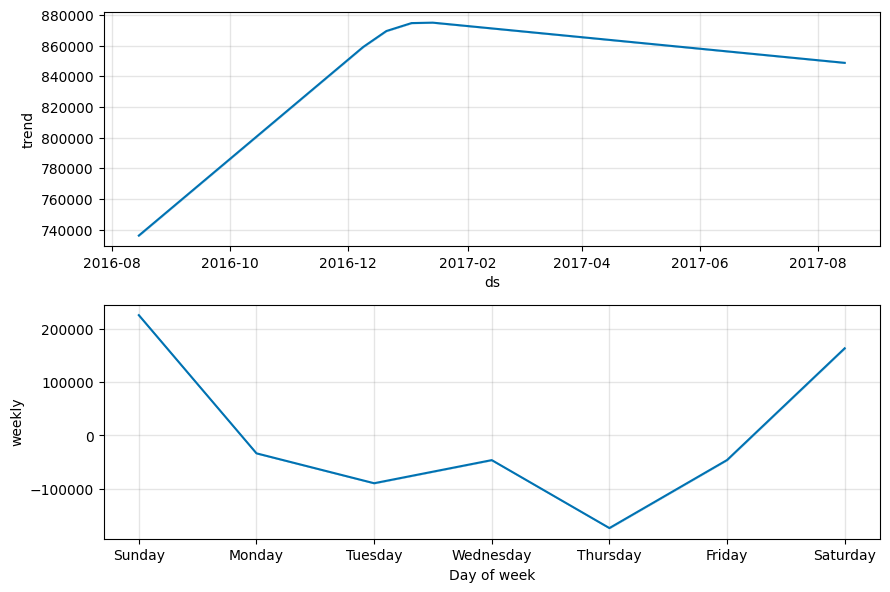

In [71]:
fig = model_prophet.plot_components(train_forecast)

Overall, we have higher sales numbers during christmas time and in particular on weekends.

Since we only included parts of our data into Facebook model we decide to choose the LSTM model for predicting on the test data and make our submission. For this purpose we need to bring our test data into the right shape in order to feed it into the LSTM model.

In [72]:
# reshape and predict on test data
X_test_pred = pivot_train_lstm_valid_scaled[-number_past:,:].reshape((1, number_past, number_features))
test_pred_scaled = best_model.predict(X_test_pred)

1/1 [==============================] - 1s 732ms/step


Before interpreting our results we have to undo our transformation process of the input data where we scaled values on a range from 0 to 1. 

In [73]:
# undo 0 to 1 scaling
y_predict = pd.DataFrame(minmax.inverse_transform(test_pred_scaled.reshape((number_future, number_features))),columns=pivot_train_lstm_valid.columns)

In [74]:
y_predict

store_nbr         1                                                 \
family           0             1         2            3         4    
0          5.256021  4.005556e-16  3.457208  2464.833008  0.315448   
1          4.546299  1.375284e-15  3.187742  2100.773682  0.176860   
2          4.801962  1.701139e-15  3.528824  2403.022461  0.201923   
3          5.295043  1.722553e-15  3.898739  2552.102295  0.071790   
4          2.232006  2.588412e-15  2.447601  1321.520630 -0.059866   
5          4.442551  2.703454e-15  4.017437  2523.484619  0.252121   
6          4.734094  2.838897e-15  3.699356  2347.869141  0.227417   
7          4.313683  2.411395e-15  3.783852  2464.246826  0.241797   
8          4.012762  1.183682e-15  3.339900  2014.184570  0.291917   
9          4.236929  1.732061e-15  3.543504  2216.439697  0.253203   
10         4.523750  2.131741e-15  3.886915  2284.793457  0.202606   
11         1.920371  2.994910e-15  2.522542  1326.406494  0.075569   
12         3.982944  3.061985e-15  4.063263  2254.289307  0.118825   
13         4.049322  2.890563e-15  3.935071  2230.851562  0.247886   
14         4.128272  2.398737e-15  4.087825  2375.526611  0.255271   
15         3.940352  2.100058e-15  3.897707  2174.618896  0.170132   

store_nbr                                                             ...  \
family             5          6           7           8           9   ...   
0          461.766022  14.922505  812.696350  863.822754  151.761810  ...   
1          424.579102  20.785048  723.629150  753.266541  137.917862  ...   
2          453.295532  22.196501  790.043701  848.443909  169.653763  ...   
3          449.196472  18.540634  707.876160  862.558289  158.755600  ...   
4          212.072540  10.517794  335.089478  436.488739   77.296211  ...   
5          473.541687  24.997580  783.995483  852.246460  162.424637  ...   
6          409.189087  14.539261  727.519348  775.868713  143.453232  ...   
7          492.778809  23.257284  858.965515  895.339050  153.460724  ...   
8          408.868958  20.777384  695.565857  714.341248  126.045517  ...   
9          424.697510  21.743454  753.993225  784.981812  163.005798  ...   
10         427.356750  15.563270  656.363647  803.129883  145.693878  ...   
11         238.949097  12.995348  386.388794  451.578461   82.979828  ...   
12         420.056305  22.611780  689.773010  776.911316  147.264328  ...   
13         424.717255  22.167984  735.090393  769.866577  148.613998  ...   
14         475.175873  21.341269  845.727478  869.637512  152.738724  ...   
15         414.567749  20.262157  704.036560  763.571350  139.970184  ...   

store_nbr         9                                                            \
family           23          24          25         26         27          28   
0          2.459592  371.296722  528.740906   5.973021  10.769874  475.705017   
1          2.106279  442.263062  453.587402   5.593771   8.499487  413.073486   
2          2.142283  324.359863  425.348633   5.888298   9.228980  425.647980   
3          3.017646  493.774445  806.432251   9.582850  18.229927  626.578430   
4          4.196381  528.344177  911.971069  11.255862  21.955353  733.335632   
5          1.620123  409.703094  567.740295   5.992669  11.652448  454.244415   
6          2.596881  469.643890  783.532654   8.544852  16.636274  607.806152   
7          1.824724  380.726288  528.990845   5.853813   9.820017  406.039581   
8          2.178548  476.067871  397.603088   4.837296   9.152624  390.244720   
9          2.204594  319.679688  415.032043   5.744444   9.749006  424.852325   
10         3.834672  418.743805  610.404175   7.750535  14.836705  531.503967   
11         3.397068  437.311432  640.081299   8.410954  15.732559  576.518555   
12         2.097193  410.755096  614.983643   7.094816  13.874924  489.795532   
13         1.933377  378.615265  552.512756   6.181370  11.948606  438.282898   
14         1.856712  366.629974  481.849823   5.310940  

The pivot table shows our predicted results which look reasonable on the first glance. The rows represent the number of days we predicted on, namely 16 days. However the format is still a pivot table and we need a standard dataframe for our submission. In order to get matching pairs of ID's and sales number we create a second view of our pivot table where we set ID to be the 'values' parameter. This way both pivot tables provide us the matching value pairs. For example the first row in our submission will be ID = 3000888 and sales = 5.256021.

In [75]:
pivoted_test = df_test_lstm.pivot(index=['date'], columns=['store_nbr', 'family'], values='id')
pivoted_test

store_nbr         1                                                        \
family           0        1        2        3        4        5        6    
date                                                                        
2017-08-16  3000888  3000889  3000890  3000891  3000892  3000893  3000894   
2017-08-17  3002670  3002671  3002672  3002673  3002674  3002675  3002676   
2017-08-18  3004452  3004453  3004454  3004455  3004456  3004457  3004458   
2017-08-19  3006234  3006235  3006236  3006237  3006238  3006239  3006240   
2017-08-20  3008016  3008017  3008018  3008019  3008020  3008021  3008022   
2017-08-21  3009798  3009799  3009800  3009801  3009802  3009803  3009804   
2017-08-22  3011580  3011581  3011582  3011583  3011584  3011585  3011586   
2017-08-23  3013362  3013363  3013364  3013365  3013366  3013367  3013368   
2017-08-24  3015144  3015145  3015146  3015147  3015148  3015149  3015150   
2017-08-25  3016926  3016927  3016928  3016929  3016930  3016931  3016932   
2017-08-26  3018708  3018709  3018710  3018711  3018712  3018713  3018714   
2017-08-27  3020490  3020491  3020492  3020493  3020494  3020495  3020496   
2017-08-28  3022272  3022273  3022274  3022275  3022276  3022277  3022278   
2017-08-29  3024054  3024055  3024056  3024057  3024058  3024059  3024060   
2017-08-30  3025836  3025837  3025838  3025839  3025840  3025841  3025842   
2017-08-31  3027618  3027619  3027620  3027621  3027622  3027623  3027624   

store_nbr                              ...        9                    \
family           7        8        9   ...       23       24       25   
date                                   ...                              
2017-08-16  3000895  3000896  3000897  ...  3002660  3002661  3002662   
2017-08-17  3002677  3002678  3002679  ...  3004442  3004443  3004444   
2017-08-18  3004459  3004460  3004461  ...  3006224  3006225  3006226   
2017-08-19  3006241  3006242  3006243  ...  3008006  3008007  3008008   
2017-08-20  3008023  3008024  3008025  ...  3009788  3009789  3009790   
2017-08-21  3009805  3009806  3009807  ...  3011570  3011571  3011572   
2017-08-22  3011587  3011588  3011589  ...  3013352  3013353  3013354   
2017-08-23  3013369  3013370  3013371  ...  3015134  3015135  3015136   
2017-08-24  3015151  3015152  3015153  ...  3016916  3016917  3016918   
2017-08-25  3016933  3016934  3016935  ...  3018698  3018699  3018700   
2017-08-26  3018715  3018716  3018717  ...  3020480  3020481  3020482   
2017-08-27  3020497  3020498  3020499  ...  3022262  3022263  3022264   
2017-08-28  3022279  3022280  3022281  ...  3024044  3024045  3024046   
2017-08-29  3024061  3024062  3024063  ...  3025826  3025827  3025828   
2017-08-30  3025843  3025844  3025845  ...  3027608  3027609  3027610   
2017-08-31  3027625  3027626  3027627  ...  3029390  3029391  3029392   

store_nbr                                                                  
family           26       27       28       29       30       31       32  
date                                                                       
2017-08-16  3002663  3002664  3002665  3002666  3002667  3002668  3002669  
2017-08-17  3004445  3004446  3004447  3004448  3004449  3004450  3004451  
2017-08-18  3006227  3006228  3006229  3006230  3006231  3006232  3006233  
2017-08-19  3008009  3008010  3008011  3008012  3008013  3008014  3008015  
2017-08-20  3009791  3009792  3009793  3009794  3009795  3009796  3009797  
2017-08-21  3011573  3011574  3011575  3011576  3011577  3011578  3011579  
2017-08-22  3013355  3013356  3013357  3013358  3013359  3013360  3013361  
2017-08-23  3015137  3015138  3015139  3015140  3015141  3015142  3015143  
2017-08-24  3016919  3016920  3016921  3016922  3016923  3016924  3016925  
2017-08-25  3018701  3018702  3018703  3018704  3018705  3018706  3018707  
2017-08-26  3020483  3020484  3020485  3020486  3020487  3020488  3020489  
2017-08-27  3022265  3022266  3022267  3022268  3022269  3022270  3022271  
2017-08-

We create an empty submission dataframe to fill in our predicted values for the corresponding ID's. In order to do this we take the corresponding value pairs from the two pivot tables above.

In [78]:
# map ID and sales from pivot tables to submission format
dic_submission = {"id": [], "sales": []}

# iterate all rows (=days)
for day_index, row in y_predict.iterrows():
    # iterate all sales per day
    for sales_index in range(len(row)):
        # get id (and convert to integer)
        sales_id = pivoted_test.iloc[[day_index], [sales_index]].values[0][0].astype(int)
        # get sales number (set negative sales to 0)
        sales_number= max(0,row.values[sales_index])
        
        # add a new entry to the results dictionary
        dic_submission["id"].append(sales_id)
        dic_submission["sales"].append(sales_number)
        
df_mysubmission = pd.DataFrame(dic_submission)

In [79]:
df_mysubmission

,id,sales
0,3000888,5.256021e+00
1,3000889,4.005556e-16
2,3000890,3.457208e+00
3,3000891,2.464833e+03
4,3000892,3.154476e-01
...,...,...
28507,3029395,4.677527e+02
28508,3029396,1.311734e+02
28509,3029397,1.571747e+03
28510,3029398,2.902064e+01


In [80]:
df_mysubmission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


That looks good! Now we create a CSV submission file and check our score.

In [81]:
df_mysubmission.to_csv('submission.csv', index = False)

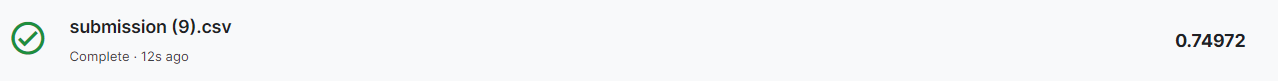

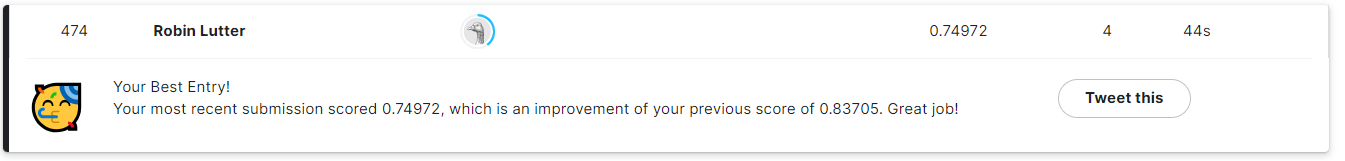

We obtain a score of 0.74972 and a place 474 on the leaderboard while improving on our results in comparison to the previous submission!

# 8. Conclusion

## 8.1 Result Summary

We worked and experimented with two different models, namely LSTM and Facebook Prophet. In the end, we used the LSTM model for predicting on the test data and achieved a solid score on the leaderboard. Additonally, we could draw some meaningful insight from the Prophet mode especially when it comes to trends and seasonality aspects. 

## 8.2 Learnings and Takeaways

Working with neural networks requires a unique workflow, differing from simpler supervised learning approaches. The training of models in this context can be very time-intensive. An often underestimated but very useful practice involves the careful incorporation of print statements within our code. These statements help us in effective debugging, making it easier to inspect intermediate results and identify errors.

Additionally, we had some problems with the limitation of memory and time resources on the GPU made available by Kaggle during the training of the Facebook Prophet. One takeaway in this context would be that oftentimes we cannot work with the full dataset available but rather have to make some compromise between the quality of results and its computation time.

## 8.3 What didn't work

During my first iterations on this project I tried to feed the training dataset as it is into the LSTM model without taking care of the redundant date entries. This led to bad or meaningless training results. One learning I can take away from this is that we have to carefully think about the right format of our data that we feed into our models. In this case the solution that worked for me was the represenation of the dataframe as pivot table. The Facebook Prophet model on the other hand also has its special requirements when it comes to data format. For example, you have to give the columns a certain naming in order to be recognized by the model.

And as already stated, feeding the whole training data into the Facebook model led to exceeding the available RAM which is why we had to cut off some of the data. 

## 8.4 Possible improvements

Including more information into our model, like holiday information, store informastion, or more training data (in the case of Facebook model) would potentially lead to more accurate results. Besides that - if we had enough computing power - we could expand our hyperparameter tuning by including more parameters and a wider value range. We could also experiment with totally different models and compare their results.